# `diurnal` Library Demonstration

This notebook shows how to use the `diurnal` library to determine RNA
secondary structures with neural networks. It goes through all the steps to
obtain training data, define a neural network, train it, and evaluate it.

The following requirements must be met to execute the notebook:

- A Python virtual environment installed as described in the `readme.rst` file
  of the project.
- Read and write permission in the working directory.
- At least 200 MB of ROM.

## 1. Obtain Data

The module `diurnal.database` can download the following RNA databases:

| Database name  | Number of molecules | URL of the original database
| -------------- | ------------------- | ------------------------------
| archiveII      | 3975 | https://rna.urmc.rochester.edu/pub/archiveII.tar.gz |
| RNASTRalign    | 37149 | https://www.urmc.rochester.edu/rna/ |
| RNA_STRAND     | 4666 | http://www.rnasoft.ca/strand/ |

The code snippet below downloads the `ArchiveII` dataset:

In [1]:
from diurnal import database

database.download("./data/", "archiveII")

2024-06-23T20:44:06.886134 > INFO Download and install an RNA database.
2024-06-23T20:44:06.914746 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.


`archiveII` is the name of the dataset to download and `./data/` is the directory in which the data are written. RNA molecules are described with two structures:

- The **primary structure** is a *sequence* of nuclotides, which is represented by a string of four characters: `A`, `C`, `G`, and `U`.
- The **secondary structure** describes the *pairing* of nucleotides, which is represented in the databases by a list of indices. The value `0` indicates that a nucleotide is unpaired.

## 2. Pre-process Data

Since neural networks use numerical vectors as inputs and outpus, the content of RNA databases must be converted into numerical types for training.

The **primary structure** (for instance, `AAACCCUUU`) can be converted in two main ways:

- **One-hot encoding** consists in assigning an orthogonal vector to each different letter.
- **Potential pairing matrices** represent all possible base pairings.

The **secondary structure** (for instance, `[8, 7, 6, -1, -1, -1, 2, 1, 0]`) can be used as it is, but this representation is difficult to use for predictions. The secondary structure can be converted into simpler representations:

- The **dot-bracket notation** represents unpaired nucleotides with the character `.` and paired nucleotides with the character `(` or `)` depending on whether the paired base is located nearer the 5' or 3' end of the molecule. The bracket notation can then be one-hot encoded. It cannot represent pseudo-knots, so it cannot predict all types of RNA secondary structures.
- The **shadow** represents paired nucleotide with the number `0` and paired nucleotides with the character `1`. This representation does not fully describe the secondary structure, but it is simpler to predict.
- A **pairing matrix** is a 2D matrix of boolean elements. The index of the rows and columns correspond to the index of nucleotides. If two nucleotides are paired, the element that matches their row and column is set to 0. Otherwise, the element is set to 0. This encode fully represents the secondary structure and can be used to predict pseudo-knots.

For example:

In [2]:
from diurnal.structure import Primary, Secondary, Schemes

primary_structure = "AAACCCUUU"
secondary_structure = [8, 7, 6, -1, -1, -1, 2, 1, 0]

print("One-hot encoded primary structure:")
print(Primary.to_onehot(primary_structure))
print()

print("Potential pairing matrix of the primary structure:")
print(Primary.to_matrix(primary_structure, map = Schemes.IUPAC_PAIRINGS_SCALARS))
print()

print("Bracket notation of the secondary structure:")
print(Secondary.to_bracket(secondary_structure))
print()

print("One-hot encoded secondary structure:")
print(Secondary.to_onehot(secondary_structure))
print()

print("Shadow of the secondary structure:")
print(Secondary.to_shadow(secondary_structure))
print()

print("Contact matrix of the secondary structure:")
print(Secondary.to_matrix(secondary_structure))
print()

One-hot encoded primary structure:
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]

Potential pairing matrix of the primary structure:
[[0 0 0 0 0 0 2 2 2]
 [0 0 0 0 0 0 2 2 2]
 [0 0 0 0 0 0 2 2 2]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [2 2 2 0 0 0 0 0 0]
 [2 2 2 0 0 0 0 0 0]
 [2 2 2 0 0 0 0 0 0]]

Bracket notation of the secondary structure:
['(', '(', '(', '.', '.', '.', ')', ')', ')']

One-hot encoded secondary structure:
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]]

Shadow of the secondary structure:
[1 1 1 0 0 0 1 1 1]

Contact matrix of the secondary structure:
[[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]



The matrices are difficult to visualize in the console output, so you can use
the `visualize` module to view them as heatmaps.

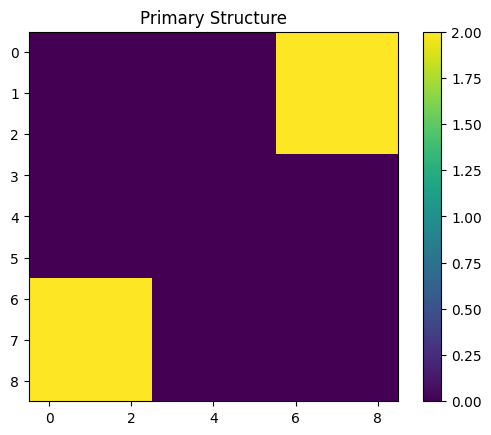

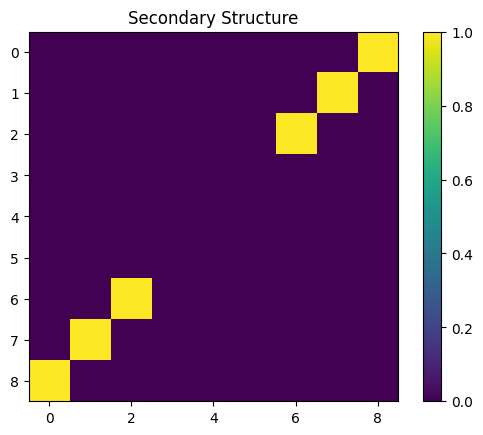

In [3]:
from diurnal import visualize

visualize.heatmap(
    Primary.to_matrix(primary_structure, map = Schemes.IUPAC_PAIRINGS_SCALARS),
    title = "Primary Structure"
)
visualize.heatmap(
    Secondary.to_matrix(secondary_structure), title = "Secondary Structure"
)

The function `diurnal.potential_pairings` can be used to visualize the primary
and secondary structures in the same graph:

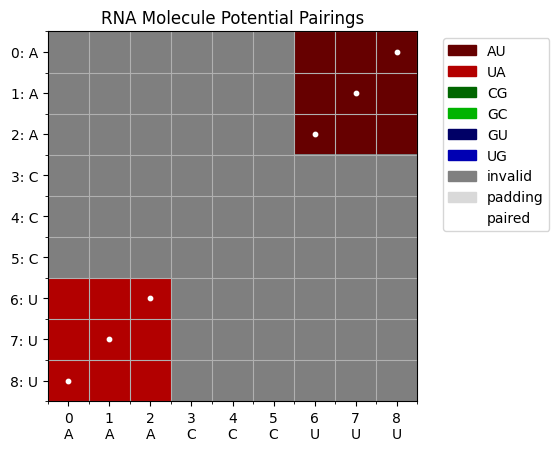

In [4]:
visualize.potential_pairings(primary_structure, secondary_structure)

Pre-processed structures can be stored on disk with Numpy files. When you
re-run the notebook, the formatting function will notice that the structures
are already encoded and will skip this step, which decreases execution time.

In [5]:
from diurnal import train

NORMALIZED_SIZE = 256
SRC = "./data/archiveII/"
DST = f"./data/archiveII_processed_{NORMALIZED_SIZE}/"
names = database.format_filenames(SRC, DST + "names.txt", NORMALIZED_SIZE)
train_names, validation_names, test_names = train.split(names, (0.8, 0.1, 0.1))

def format(dst: str, names: list[str]):
    pp_scalar = lambda x, y: Primary.to_matrix(
        x, y, Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", NORMALIZED_SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", NORMALIZED_SIZE, Primary.to_mask
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", NORMALIZED_SIZE,
        Secondary.to_matrix
    )

format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-23T20:44:37.192521 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:13<00:00, 305.05it/s]  


2024-06-23T20:44:50.257569 >     Detected 3975 files. Kept 2466 files.
2024-06-23T20:44:50.294417 >     The file `./data/archiveII_processed_256/names.txt` already contains the names.
2024-06-23T20:44:50.324872 > INFO Formatting primary structures into `./data/archiveII_processed_256/validation/primary_potential_pairings_scalar.npy`.
2024-06-23T20:44:50.427483 >     The file `./data/archiveII_processed_256/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-23T20:44:50.432633 > INFO Formatting primary structures into `./data/archiveII_processed_256/validation/primary_masks.npy`.
2024-06-23T20:44:50.535834 >     The file `./data/archiveII_processed_256/validation/primary_masks.npy` already contains the formatted data.
2024-06-23T20:44:50.538484 > INFO Formatting secondary structures into `./data/archiveII_processed_256/validation/secondary_contact.npy`.
2024-06-23T20:44:50.649065 >     The file `./data/archiveII_processed_256/validation/seconda

The notebook `demo/data_processing.ipynb` shows more examples.

## 3. Train a Model

The library contains examples of predictive models that can be loaded, trained, and evaluated as shown below:

In [10]:
import torch
import numpy as np
from diurnal import models
from diurnal.models.deep import cnn

train_set = {
    "input": (np.load(f"{DST}train/primary_potential_pairings_scalar.npy"), ),
    "output": np.load(f"{DST}train/secondary_contact.npy"),
    "mask": np.load(f"{DST}train/primary_masks.npy"),
    "names": train_names
}
validation_set = {
    "input": (np.load(f"{DST}validation/primary_potential_pairings_scalar.npy"), ),
    "output": np.load(f"{DST}validation/secondary_contact.npy"),
    "mask": np.load(f"{DST}validation/primary_masks.npy"),
    "names": validation_names
}

model = models.deep.NN(
    model=cnn.UNet2D(NORMALIZED_SIZE, 4),
    n_epochs=100,
    optimizer=torch.optim.Adam,
    loss_fn=torch.nn.CrossEntropyLoss,
    use_half=False,
    patience=5,
    verbosity=2
)
model.train(train_set, validation_set)

2024-06-23T21:23:40.946600 > INFO Training the model with 1972 data points.
2024-06-23T21:23:40.948617 >     Using 246 data points for validation.
2024-06-23T21:23:40.949625 >     Beginning the training.
2024-06-23T21:23:45.392194 >   0 / 100 [                                                  ] Loss: 1.25897  Patience: 5
2024-06-23T21:23:47.273613 >   1 / 100 [                                                  ] Loss: 1.24292  Patience: 5
2024-06-23T21:23:49.120114 >   2 / 100 [=                                                 ] Loss: 1.23586  Patience: 5
2024-06-23T21:23:50.926245 >   3 / 100 [=                                                 ] Loss: 1.22977  Patience: 5
2024-06-23T21:23:52.733608 >   4 / 100 [==                                                ] Loss: 1.22514  Patience: 5
2024-06-23T21:23:54.558216 >   5 / 100 [==                                                ] Loss: 1.22304  Patience: 5
2024-06-23T21:23:56.365054 >   6 / 100 [===                                       

In this example above, the object `diurnal.models.deep.NN` is a model that wraps a `pytorch` neural network. The model receives as arguments an optimizer and loss function that are used to train the network.

## 4. Predict Structures

Trained models can predict secondary structures from primary structures as follows:

In [19]:
test_primary_structures = np.load(f"{DST}test/primary_potential_pairings_scalar.npy")
test_masks = np.load(f"{DST}test/primary_masks.npy")
test_secondary_structures = np.load(f"{DST}test/secondary_contact.npy")

index = 0
prediction = model.predict([test_primary_structures[index]])

We can visualize the prediction result and compare it to the real structure.

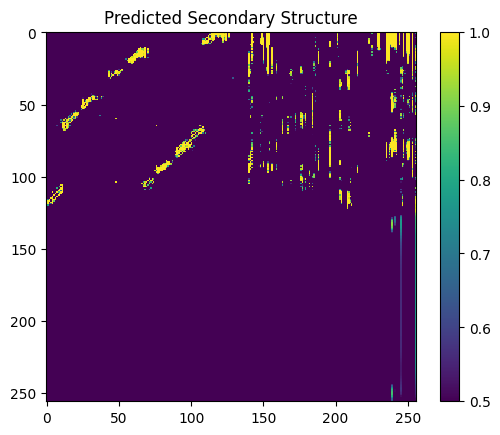

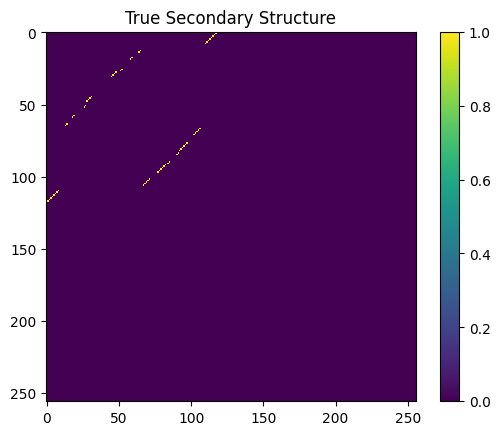

In [21]:
visualize.heatmap(prediction, "Predicted Secondary Structure")
visualize.heatmap(test_secondary_structures[index], "True Secondary Structure")

The predicted matrix can be refined into a secondary structure by performing
the following operations:

- Remove invalid pairing by multiplying the prediction by the mask.
- Make the prediction matrix symmetrical by multiplying it by its transpose.
- Convert the matrix to a monomial matrix.
- Convert the matrix to a binary matrix
- Remove isolated points with a low-pass filter.

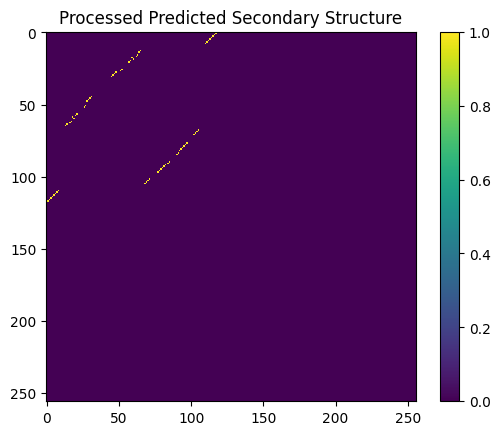

In [23]:
from diurnal import transform, segment

prediction *= test_masks[index]
prediction *= prediction.T
prediction = transform.to_monomial_matrix(prediction)
prediction = transform.to_binary_matrix(prediction)
prediction = segment.convolutional_denoise(prediction, threshold=2)

visualize.heatmap(prediction, "Processed Predicted Secondary Structure")

## 5. Evaluate Results

Predictions can be evaluated with two metrics:

- **Recall** (or sensitivity or true positive rate) is the probability that a positive prediction is actually positive.
- **Precision** (or positive predictive value) is the fraction of relevant elements among retrieved elements.

The F1-score is the geometric mean of recall and precision.

In [25]:
from diurnal import evaluate

f1 = evaluate.ContactMatrix.f1(test_secondary_structures[index], prediction)
print(f"F1 score: {f1}")

F1 score: 0.89552241563797


We can also visualize the true and predicted structures in a single graph:

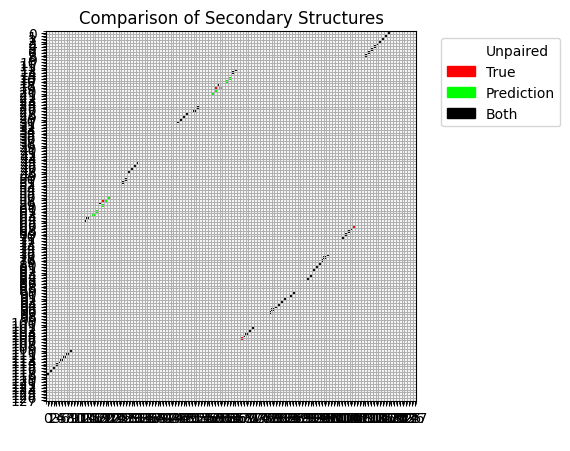

In [28]:
# Here we select to top left corner of the matrix to ease visualization.
visualize.compare_pairings(
    test_secondary_structures[index][:128, :128],
    prediction[:128, :128]
)

## 6. Save Models

Predictive models can be written in the file system to be loaded and used subsequently.

In [29]:
model.save(directory = "saved_model")

2024-06-23T21:49:12.291210 > INFO Saving the model at `saved_model/`.


The directory in which the model is saved contains two additional text files:

- `info.rst` contains metadata, such as save time and the data format used by
  the model.
- `training_molecule_list.txt` contains the list of molecules that were used
  for training.

## 7. Load Models

Models can be loaded from the file system to replicate results.

In [30]:
from diurnal import models

model = models.deep.NN(
    model=cnn.UNet2D(NORMALIZED_SIZE, 4),
    n_epochs=100,
    optimizer=torch.optim.Adam,
    loss_fn=torch.nn.CrossEntropyLoss,
    use_half=False,
    patience=5,
    verbosity=2
)
model.load("saved_model")

2024-06-23T21:51:33.973410 > INFO Loading the model from the files at `saved_model/`.
